<a href="https://colab.research.google.com/github/devguno/CAMUS/blob/main/video_predictor_echo1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video segmentation with SAM 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
import torchvision
import sys
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: True


In [ ]:
!pip install hydra-core
!pip install iopath

## Environment Set-up

In [ ]:
# !{sys.executable} -m pip install opencv-python matplotlib

# # GitHub 저장소 클론
# !git clone https://github.com/facebookresearch/sam2.git /content/drive/MyDrive/sam_project

# # 체크포인트 다운로드
# checkpoint_path = "/content/drive/MyDrive/sam_project/checkpoints"
# checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt"
# !wget -P {checkpoint_path} {checkpoint_url}

## Set-up

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [ ]:
# 경로 설정
SAM2_ROOT = "/content/drive/MyDrive/sam_project"
CHECKPOINTS_DIR = "/content/drive/MyDrive/sam_project/checkpoints"
MODEL_CONFIG = "sam2.1/sam2.1_hiera_l.yaml"
CHECKPOINT_FILE = "sam2.1_hiera_large.pt"
sys.path.append(SAM2_ROOT)

In [ ]:
import sys
import os
import torch
import hydra
from omegaconf import OmegaConf
from sam2.build_sam import build_sam2_video_predictor


# Python 경로에 SAM2 루트 추가
sys.path.append(SAM2_ROOT)

def initialize_hydra():
    """Hydra 초기화 함수"""
    hydra.core.global_hydra.GlobalHydra.instance().clear()

    # 현재 작업 디렉토리를 SAM2_ROOT로 변경
    original_cwd = os.getcwd()
    os.chdir(SAM2_ROOT)

    try:
        # 상대 경로 사용
        hydra.initialize(config_path="sam2/configs", version_base=None)
    finally:
        # 원래 작업 디렉토리로 복원
        os.chdir(original_cwd)

def build_predictor():
    """SAM2 비디오 예측기 빌드 함수"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    checkpoint_path = os.path.join(CHECKPOINTS_DIR, CHECKPOINT_FILE)

    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"체크포인트 파일을 찾을 수 없습니다: {checkpoint_path}")

    try:
        initialize_hydra()
        predictor = build_sam2_video_predictor(MODEL_CONFIG, checkpoint_path, device=device)
        print("Video predictor built successfully!")
        return predictor
    except Exception as e:
        print(f"Error building video predictor: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# predictor 생성
predictor = build_predictor()
print(f"Predictor type: {type(predictor)}")

/content/drive/MyDrive/sam_project/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


Video predictor built successfully!
Predictor type: <class 'sam2.sam2_video_predictor.SAM2VideoPredictor'>


In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [75]:
import cv2
import os

def extract_frames(video_path, output_folder, frame_interval=10):
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"{saved_count + 1}.jpg")
            cv2.imwrite(frame_filename, frame, [cv2.IMWRITE_JPEG_QUALITY, 100])
            saved_count += 1

        frame_count += 1

    cap.release()

    return frame_count, saved_count

# 입력 및 출력 디렉토리 설정
input_dir = "/content/drive/MyDrive/sam_project/echo/video"
output_base_dir = "/content/drive/MyDrive/sam_project/echo/frame"

# 입력 디렉토리의 모든 AVI 파일에 대해 처리
for filename in os.listdir(input_dir):
    if filename.endswith(".avi"):
        video_path = os.path.join(input_dir, filename)
        output_folder = os.path.join(output_base_dir, os.path.splitext(filename)[0])
        os.makedirs(output_folder, exist_ok=True)

        total_frames, saved_frames = extract_frames(video_path, output_folder)

        print(f"처리된 파일: {filename}")
        print(f"영상의 프레임 수: {total_frames}")
        print(f"저장된 프레임 수: {saved_frames}")
        print(f"저장 형식: JPEG (최고 품질)")
        print("------------------------")

print("모든 비디오 처리 완료")

처리된 파일: 0XF760A47D31AE457.avi
영상의 프레임 수: 171
저장된 프레임 수: 18
저장 형식: JPEG (최고 품질)
------------------------
처리된 파일: 0XF99271B5D3D9AE3.avi
영상의 프레임 수: 196
저장된 프레임 수: 20
저장 형식: JPEG (최고 품질)
------------------------
처리된 파일: 0XF7AF4EDD2224855.avi
영상의 프레임 수: 132
저장된 프레임 수: 14
저장 형식: JPEG (최고 품질)
------------------------
처리된 파일: 0XFA9EA2F22209920.avi
영상의 프레임 수: 145
저장된 프레임 수: 15
저장 형식: JPEG (최고 품질)
------------------------
처리된 파일: 0XF829F634971A0F7.avi
영상의 프레임 수: 183
저장된 프레임 수: 19
저장 형식: JPEG (최고 품질)
------------------------
처리된 파일: 0XFA2F04D15D5D222.avi
영상의 프레임 수: 185
저장된 프레임 수: 19
저장 형식: JPEG (최고 품질)
------------------------
처리된 파일: 0XF9CA1C6A7687A8D.avi
영상의 프레임 수: 208
저장된 프레임 수: 21
저장 형식: JPEG (최고 품질)
------------------------
처리된 파일: 0XFB550573BDD938A.avi
영상의 프레임 수: 201
저장된 프레임 수: 21
저장 형식: JPEG (최고 품질)
------------------------
처리된 파일: 0XFBD22BB93EE05C1.avi
영상의 프레임 수: 193
저장된 프레임 수: 20
저장 형식: JPEG (최고 품질)
------------------------
처리된 파일: 0XF7373FB1CFBE827.avi
영상의 프레임 수: 123
저장된 프레임 수: 13
저장 형식

#### Select an example video

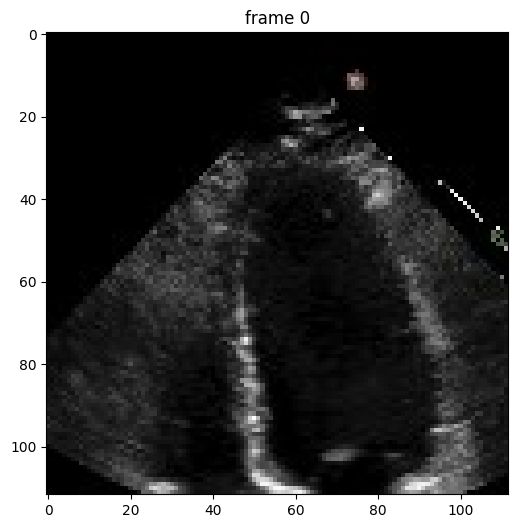

In [97]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/content/drive/MyDrive/sam_project/echo/frame/0XF7AF4EDD2224855"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
plt.show()

In [103]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 14/14 [00:00<00:00, 36.89it/s]


In [104]:
predictor.reset_state(inference_state)

In [105]:
prompts = {}  # hold all the clicks we add for visualization

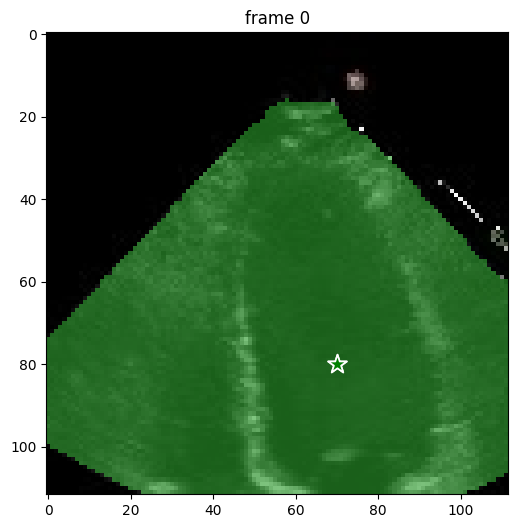

In [106]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (200, 300) to get started on the first object
points = np.array([[70, 80]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

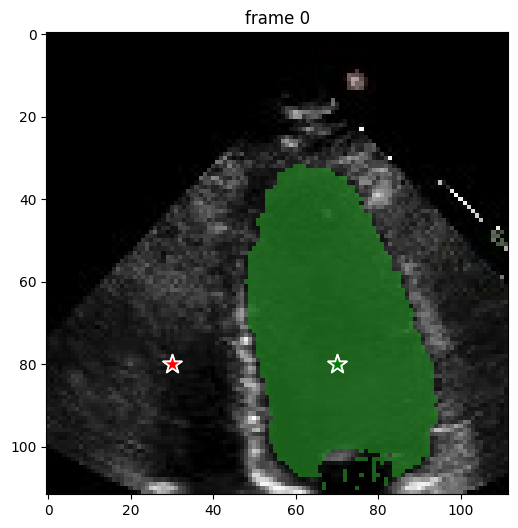

In [107]:
# add the first object
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd negative click at (x, y) = (275, 175) to refine the first object
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([[70, 80], [30, 80]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 0], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

propagate in video: 100%|██████████| 14/14 [00:16<00:00,  1.19s/it]


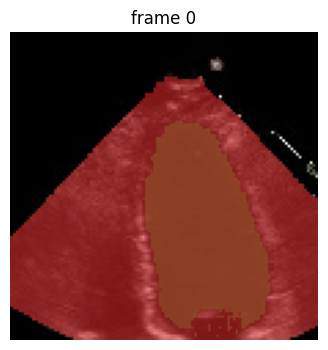

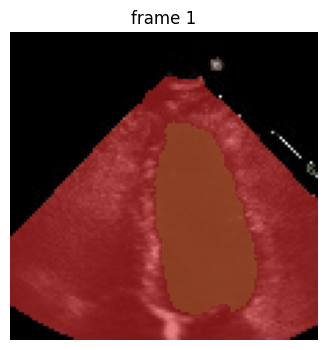

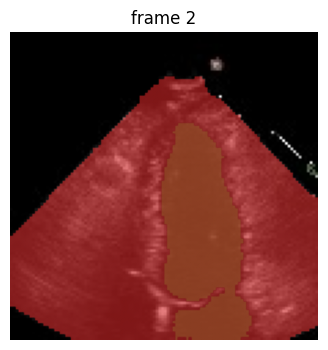

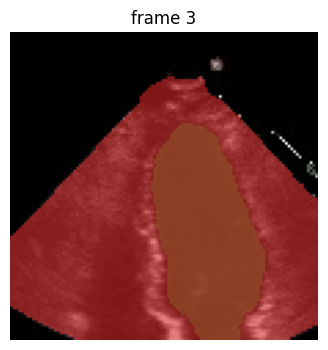

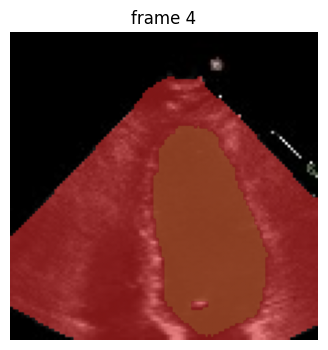

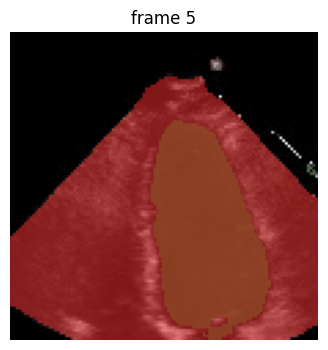

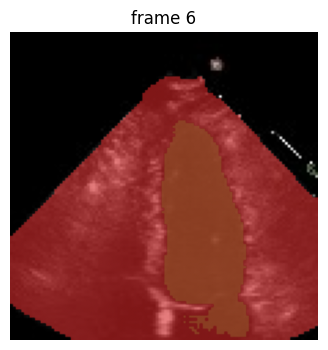

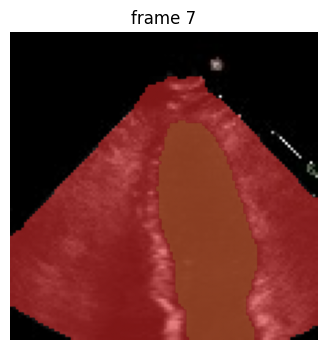

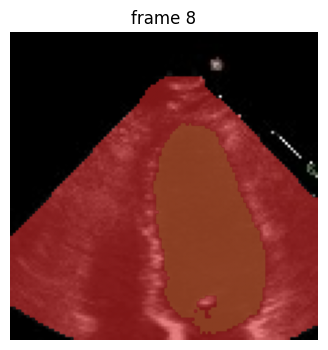

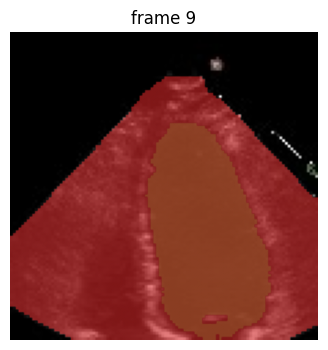

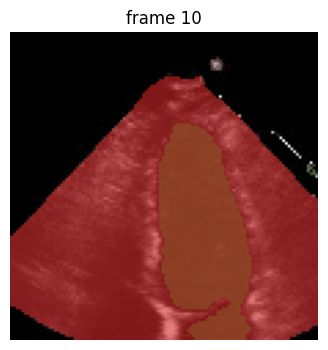

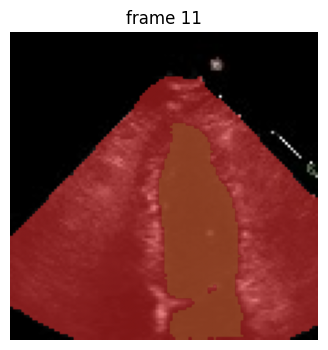

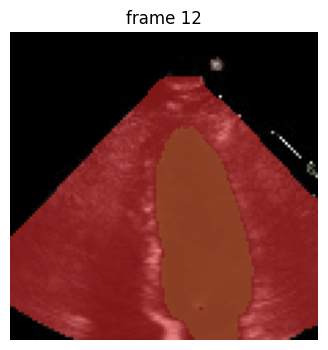

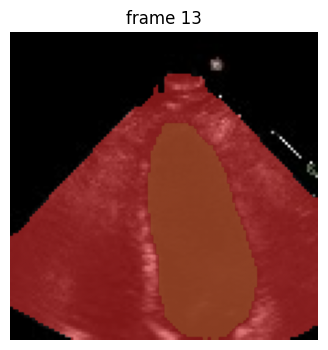

세그멘테이션 이미지가 /content/drive/MyDrive/sam_project/echo/segment/0XF7AF4EDD2224855에 저장되었습니다.


In [109]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# 새로운 폴더 경로 설정
new_dir = "/content/drive/MyDrive/sam_project/echo/segment/0XF7AF4EDD2224855"

# 새 폴더 생성
os.makedirs(new_dir, exist_ok=True)

# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")

    # 원본 이미지 로드
    img = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    ax.imshow(img)

    # 세그멘테이션 마스크 추가
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, ax, obj_id=out_obj_id)

    # 축 제거
    plt.axis('off')

    # 이미지 저장
    save_path = os.path.join(new_dir, f"frame_{out_frame_idx:04d}.png")
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)

    # 이미지 출력
    plt.show()

    # 메모리 관리를 위해 figure 닫기
    plt.close(fig)

print(f"세그멘테이션 이미지가 {new_dir}에 저장되었습니다.")

In [112]:
import cv2
import os
import re

def create_video_from_images(image_folder, output_video_path, fps=5):
    # PNG 파일만 선택하고 파일명에서 숫자를 추출하여 정렬
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    images.sort(key=lambda x: int(re.search(r'\d+', x).group()))

    if not images:
        print(f"Error: No PNG images found in {image_folder}")
        return

    # 첫 번째 이미지를 읽어 비디오 속성 설정
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    # 비디오 작성자 객체 생성
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # 각 이미지를 비디오 프레임으로 추가
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    # 비디오 작성자 객체 해제
    cv2.destroyAllWindows()
    video.release()

    print(f"비디오가 성공적으로 생성되었습니다: {output_video_path}")

# 입력 및 출력 경로 설정
input_folder = "/content/drive/MyDrive/sam_project/echo/segment/0XF7AF4EDD2224855"
output_folder = "/content/drive/MyDrive/sam_project/echo/video_sam2"

# 입력 폴더의 마지막 부분을 파일 이름으로 사용
folder_name = os.path.basename(input_folder)
output_filename = f"{folder_name}.mp4"

# 출력 폴더가 없으면 생성
os.makedirs(output_folder, exist_ok=True)

# 출력 비디오 경로
output_video_path = os.path.join(output_folder, output_filename)

# 비디오 생성 (FPS를 5로 설정)
create_video_from_images(input_folder, output_video_path, fps=5)

# 생성된 비디오 정보 출력
video = cv2.VideoCapture(output_video_path)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(video.get(cv2.CAP_PROP_FPS))
duration = frame_count / fps

print(f"생성된 비디오 정보:")
print(f"파일 이름: {output_filename}")
print(f"프레임 수: {frame_count}")
print(f"FPS: {fps}")
print(f"재생 시간: {duration:.2f}초")
print(f"파일 크기: {os.path.getsize(output_video_path) / (1024*1024):.2f} MB")

video.release()

비디오가 성공적으로 생성되었습니다: /content/drive/MyDrive/sam_project/echo/video_sam2/0XF7AF4EDD2224855.mp4
생성된 비디오 정보:
파일 이름: 0XF7AF4EDD2224855.mp4
프레임 수: 14
FPS: 5
재생 시간: 2.80초
파일 크기: 0.06 MB
